In [ ]:
#using Pkg
#Pkg.add(path = "<path to local git repo>/STARS.jl")


In [4]:

using Dates
using Rasters
using STARS
using STARS.BBoxes
using STARS.sentinel_tiles
using STARS.HLS
using STARS.VNP43
using STARS.STARS
using LinearAlgebra
using Plots

Organizing Data

In [2]:
coarse_image_filenames = readdir("salton_sea_coarse_NIR", join=true)
coarse_images_rr = Raster.(coarse_image_filenames, missingval=NaN)

fine_image_filenames = readdir("salton_sea_fine_NIR", join=true)
fine_images_rr = Raster.(fine_image_filenames, missingval=NaN)

nr, nc = size(coarse_images_rr[1])
nfr, nfc = size(fine_images_rr[1])
nt = size(coarse_images_rr)[1]
coarse_images = Raster(fill(NaN, nr, nc, nt), dims = (coarse_images_rr[1].dims[1:2]...,Band(1:nt)),missingval=coarse_images_rr[1].missingval)
fine_images = Raster(fill(NaN, nfr, nfc, nt), dims = (fine_images_rr[1].dims[1:2]...,Band(1:nt)),missingval=fine_images_rr[1].missingval)

for i in 1:nt
    coarse_images[:,:,i] = coarse_images_rr[i]
    fine_images[:,:,i] = fine_images_rr[i]
end

fine_images[:,:,32] .= NaN
fine_images[:,:,57] .= NaN
fine_images[:,:,73] .= NaN
fine_images[:,:,89] .= NaN;

140×140×92 Raster{Float64,3} with dimensions: 
  X Projected{Float64} LinRange{Float64}(649980.0, 659710.0, 140) ForwardOrdered Regular Intervals{Start} crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(3.65977e6, 3.65004e6, 140) ReverseOrdered Regular Intervals{Start} crs: WellKnownText,
  Band Sampled{Int64} 1:92 ForwardOrdered Regular Points
extent: Extent(X = (649980.0, 659780.0), Y = (3.65004e6, 3.65984e6), Band = (1, 92))missingval: NaNcrs: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Eas

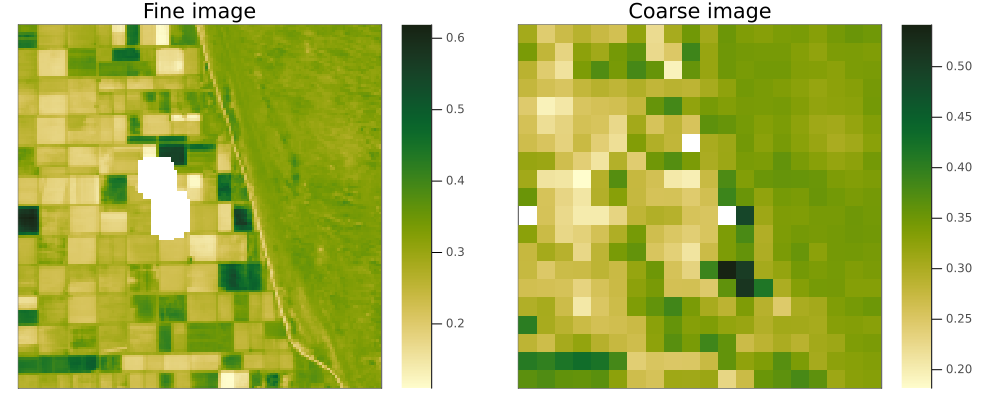

In [14]:
p1 = plot(fine_images[:,:,12], yaxis=nothing, xaxis=nothing, xlabel="", ylabel="", c=:speed,title="Fine image")
p2 = plot(coarse_images[:,:,10], yaxis=nothing, xaxis=nothing, xlabel="", ylabel="", c=:speed, title="Coarse image")
plot(p1,p2,layout=(1,2), size=(1000,400))

Setting model parameters

In [16]:

nr, nc = size(coarse_images)[1:2]

n_eff = compute_n_eff(7,2,smoothness=1.5) ## Matern: range = 200m, smoothness = 1.5
sp_var = fast_var_est(coarse_images[:,:,15:27], n_eff_agg = n_eff);
cov_raster_full = Raster(fill(NaN, nr, nc, 4), dims = (coarse_images.dims[1:2]...,Band(1:4)),missingval=fine_images.missingval)

cov_raster_full[:,:,1] = sp_var
cov_raster_full[:,:,2] .= 150
cov_raster_full[:,:,3] .= 1e-10
cov_raster_full[:,:,4] .= 1.5;

Running data fusion (Notebook TODO: pull out remaing parameter specifications)

In [ ]:
## need to update with parameter file
BLAS.set_num_threads(1) ## setting BLAS libraries to not multithread, there is a multithreaded loop inside coarse_fine_data_fusion_SS()

@time fusion_results = coarse_fine_data_fusion_SS(
    coarse_images[:,:,20:41], 
    fine_images[:,:,20:41], 
    cov_raster_full,
    prior = nothing,
    target_times = 1:20,
    buffer_distance = 100.,
    prop_subsample = 0.2,
    offset_ar = [1, 0.0], 
    offset_var = [1e-6, 1e-6],    
    default_mean = 0.12,
    smooth = false
);

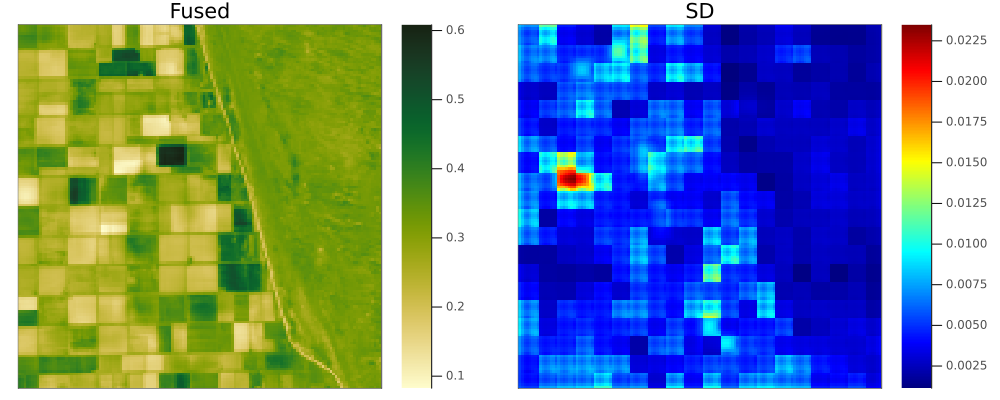

In [20]:

p1 = plot(fusion_results.mean[:,:,10], yaxis=nothing, xaxis=nothing, xlabel="", ylabel="", c=:speed, title="Fused")
p2 = plot(fusion_results.SD[:,:,10], yaxis=nothing, xaxis=nothing, xlabel="", ylabel="", c=:jet, title = "SD")
plot(p1,p2,layout=(1,2), size=(1000,400))